<a href="https://colab.research.google.com/github/abrar39/Time-Series-Forecasting/blob/master/Stock_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install psx-data-reader

In [38]:
from psx import stocks, tickers
import numpy as np
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [39]:
# Companies to scrape
companies = ['EFERT', 'ILP', 'PABC']
data = stocks(companies, start=datetime.date(2020, 1, 1), end=datetime.date.today())

/usr/local/lib/python3.10/dist-packages/psx/web.py:100: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data = pd.concat(data)
/usr/local/lib/python3.10/dist-packages/psx/web.py:100: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data = pd.concat(data)
/usr/local/lib/python3.10/dist-packages/psx/web.py:100: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat o

In [40]:
def company_eda(company_name : str, print_head : bool = True, plot_historical_values : bool = True):
  # Print the head of the company data
  if print_head:
    print("Printing Head...")
    print(data.loc[company_name].head())

  if plot_historical_values:
    # Plot the historical values of the company
    data.loc[company_name]['Close'].plot()

  # Print the summary statistics of the company
  print("Printing Summary Statistics...")
  print(data.loc[company_name].describe())

Printing Head...
             Open   High    Low  Close     Volume
Date                                             
2020-01-01  73.44  74.40  73.29  73.86  1039500.0
2020-01-02  74.15  74.57  73.60  74.01  3035000.0
2020-01-03  74.20  74.29  73.19  73.57  2232000.0
2020-01-06  72.98  73.40  71.00  72.64  1577500.0
2020-01-07  72.84  74.19  72.00  73.57  2328500.0
Printing Summary Statistics...
              Open         High          Low        Close        Volume
count  1227.000000  1227.000000  1227.000000  1227.000000  1.227000e+03
mean     92.627425    93.667873    91.670098    92.680024  1.854067e+06
std      37.570737    38.229402    36.988647    37.645724  1.820383e+06
min      50.010000    52.950000    48.990000    50.720000  1.375870e+05
25%      67.510000    68.000000    66.945000    67.550000  7.889565e+05
50%      80.300000    81.000000    79.800000    80.410000  1.334509e+06
75%      90.275000    91.440000    89.505000    90.570000  2.204892e+06
max     213.000000   215.0

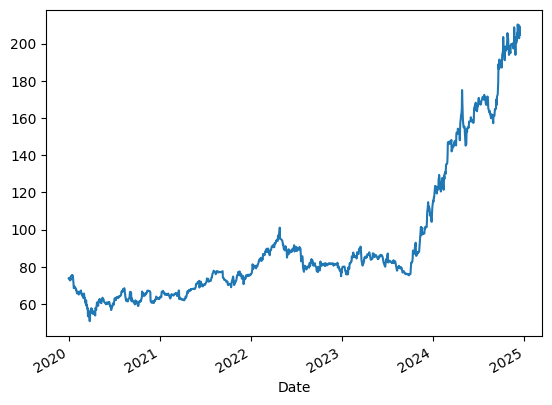

In [41]:
company_eda('EFERT')

In [42]:
def generate_windowed_data(company_data, window_size):
  periods = np.arange(1, window_size+1)  # T-1 to T-n where n = window size
  company_data = company_data.assign(**{f"Close T-{period}": company_data['Close'].shift(period) for period in periods})

  return company_data.dropna()

In [43]:
efert_data = data.loc['EFERT'].copy()
efert_data = generate_windowed_data(efert_data, 10)
efert_data.head()

,Open,High,Low,Close,Volume,Close T-1,Close T-2,Close T-3,Close T-4,Close T-5,Close T-6,Close T-7,Close T-8,Close T-9,Close T-10
Date,,,,,,,,,,,,,,,
2020-01-15,75.5,75.75,74.86,75.07,594500.0,75.56,75.05,74.94,74.83,72.84,73.57,72.64,73.57,74.01,73.86
2020-01-16,75.2,75.30,74.61,75.16,588500.0,75.07,75.56,75.05,74.94,74.83,72.84,73.57,72.64,73.57,74.01
2020-01-17,75.0,75.59,74.75,75.30,1323000.0,75.16,75.07,75.56,75.05,74.94,74.83,72.84,73.57,72.64,73.57
2020-01-20,75.1,75.15,71.16,71.17,15269000.0,75.30,75.16,75.07,75.56,75.05,74.94,74.83,72.84,73.57,72.64
2020-01-21,69.0,70.14,68.20,68.49,6675000.0,71.17,75.30,75.16,75.07,75.56,75.05,74.94,74.83,72.84,73.57


Now that we have the data ready. We can begin creation of our model for prediction.

In [44]:
# Create the X, and y arrays containing the features, and targets respectively.
def create_x_y(df, window_size):
  # select X columns
  X_columns = [f"Close T-{period}" for period in np.arange(1, window_size+1)]
  y_column = ["Close"]

  X = df[X_columns].values # we need numpy arrays for training
  y = df[y_column].values

  # Reshape the X matrix as required by the training algorithm
  X = X.reshape(X.shape[0], X.shape[1], 1) # [num_samples, sequence_length, num_features]
  #X = X.reshape(X.shape[0], 5, 1)  # [num_samples, sequence_length, num_features]
  return X.astype(np.float32), y.astype(np.float32)

In [45]:
X, y = create_x_y(efert_data, 10)
X.shape, y.shape

((1217, 10, 1), (1217, 1))

In [46]:
# Split the data into train, test, and validation sets
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, shuffle=False)

In [47]:
# convert the data into tensors for use in pytorch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [48]:
X_train.shape, y_train.shape

(torch.Size([973, 10, 1]), torch.Size([973, 1]))

# Create the Model
I shall use pytorch sequential model to create the LSTM model.

In [49]:
# select the device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
import torch
import torch.nn as nn

# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        #self.input_layer = nn.Linear(5, 5)  # Input transformation layer (if needed)
        self.lstm = nn.LSTM(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(20, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        #x = self.input_layer(x)  # Transform the input (optional, depending on data)
        lstm_out, (hidden_state, cell_state) = self.lstm(x)  # Apply LSTM
        x = self.fc1(lstm_out[:, -1, :])  # Use the last hidden state
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate and print the model
model = LSTMModel()
print(model)


LSTMModel(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


In [51]:
def train_model(model, train_loader, loss, optimizer, batch_size, device, epochs=100, patience=5):

  best_val_loss = float('inf')  # Initialize best validation loss as infinity
  epochs_since_improvement = 0  # Counter for the number of epochs without improvement

  for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)  # Pass inputs through the model
        loss = criterion(outputs, targets)  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters

        epoch_loss += loss.item()

    # Print epoch statistics
    #print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

  # Compute validation loss at the end of each epoch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        epochs_since_improvement = 0  # Reset the counter if improvement occurs
    else:
        epochs_since_improvement += 1  # Increment the counter if no improvement

    # Early stopping condition
    if epochs_since_improvement >= patience:
        print(f"Early stopping after {epoch + 1} epochs")
        break  # Stop training if no improvement after `patience` epochs

In [52]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # the optimizer

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Epochs
num_epochs = 500
patience=5 # early stopping criteria

train_model(model, train_loader, loss=criterion, optimizer=optimizer, batch_size=batch_size, device=device, epochs=num_epochs, patience=patience)

Epoch 1/500, Train Loss: 5820.6267, Val Loss: 19921.9160
Epoch 2/500, Train Loss: 5687.2395, Val Loss: 19477.7070
Epoch 3/500, Train Loss: 5345.8461, Val Loss: 18647.5898
Epoch 4/500, Train Loss: 4852.6212, Val Loss: 17553.7344
Epoch 5/500, Train Loss: 4278.1482, Val Loss: 16384.9609
Epoch 6/500, Train Loss: 3686.9450, Val Loss: 15143.2363
Epoch 7/500, Train Loss: 3097.1648, Val Loss: 13853.0381
Epoch 8/500, Train Loss: 2528.3678, Val Loss: 12556.4453
Epoch 9/500, Train Loss: 1981.1232, Val Loss: 11288.1396
Epoch 10/500, Train Loss: 1507.4198, Val Loss: 10088.7871
Epoch 11/500, Train Loss: 1108.1939, Val Loss: 8994.0664
Epoch 12/500, Train Loss: 794.9153, Val Loss: 8024.8604
Epoch 13/500, Train Loss: 554.0908, Val Loss: 7193.9917
Epoch 14/500, Train Loss: 384.7942, Val Loss: 6509.0317
Epoch 15/500, Train Loss: 272.8870, Val Loss: 5956.3115
Epoch 16/500, Train Loss: 204.2958, Val Loss: 5535.2070
Epoch 17/500, Train Loss: 163.5735, Val Loss: 5213.5942
Epoch 18/500, Train Loss: 141.4819, 

# Evaluation of the Model


In [ ]:
# Set the model to evaluation mode
model.eval()

# Create the DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store actual and predicted values
actuals = []
predictions = []

# Loop through the validation set
with torch.no_grad():  # Disable gradient calculation for validation
    for inputs, targets in val_loader:
        # Forward pass
        outputs = model(inputs)

        # Store actual and predicted values
        actuals.append(targets.numpy())
        predictions.append(outputs.numpy())

# Convert lists to numpy arrays
actuals = np.concatenate(actuals, axis=0)
predictions = np.concatenate(predictions, axis=0)

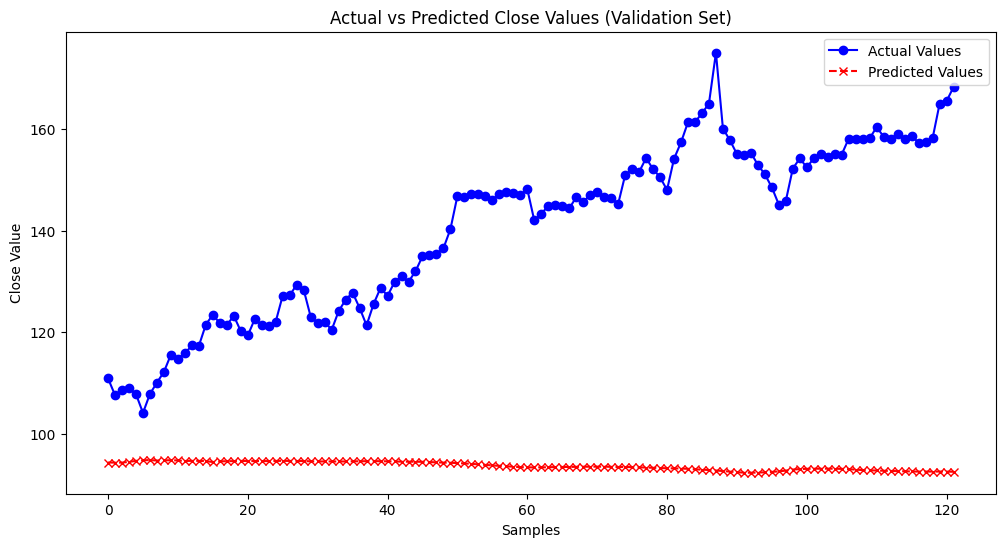

In [ ]:
# Plot actual vs predicted values for validation set
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Values", color='blue', linestyle='-', marker='o')
plt.plot(predictions, label="Predicted Values", color='red', linestyle='--', marker='x')
plt.xlabel("Samples")
plt.ylabel("Close Value")
plt.title("Actual vs Predicted Close Values (Validation Set)")
plt.legend()
plt.show()


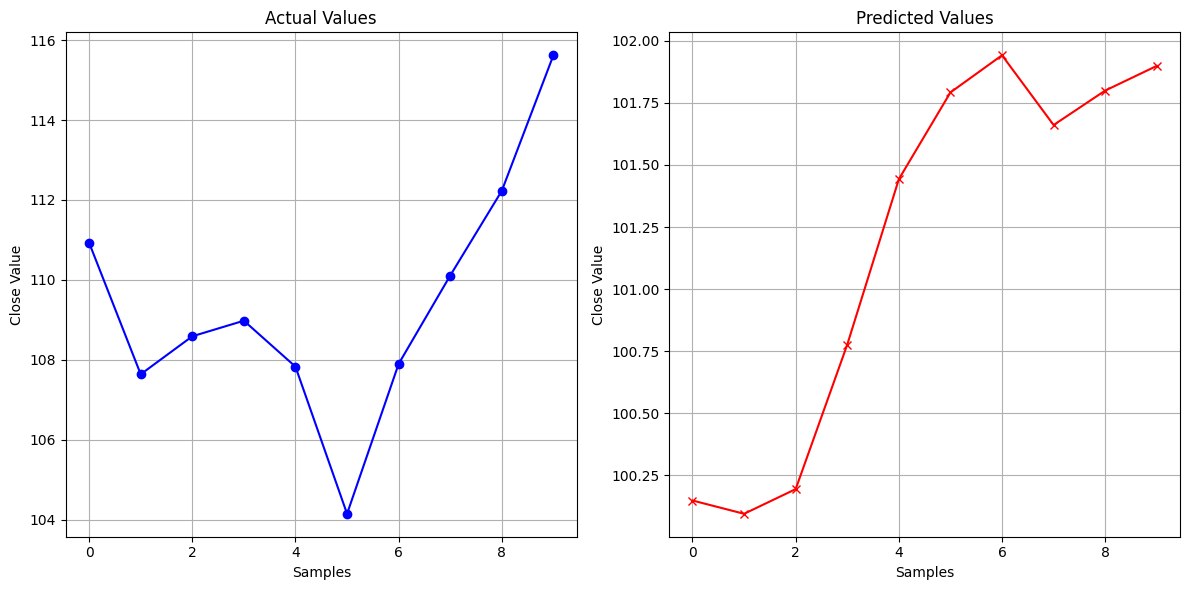

In [ ]:
# Plot actual vs predicted values for the first few samples
num_samples_to_display = 10  # Set how many samples you want to display
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.subplot(1, 2, 1)
plt.plot(actuals[:num_samples_to_display], color='blue', marker='o', label="Actual Values")
plt.title("Actual Values")
plt.xlabel("Samples")
plt.ylabel("Close Value")
plt.grid(True)

# Plot the predicted values
plt.subplot(1, 2, 2)
plt.plot(predictions[:num_samples_to_display], color='red', marker='x', label="Predicted Values")
plt.title("Predicted Values")
plt.xlabel("Samples")
plt.ylabel("Close Value")
plt.grid(True)

plt.tight_layout()
plt.show()
